<a href="https://colab.research.google.com/github/John-Polo/LAMP_assay_automation/blob/main/torchvision_train_instance_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-5nlxw2vr
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-5nlxw2vr
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=265167 sha256=461890cbe93e503851f0b571b5a106c287080c7997793cbf7d227255f1fce8cd
  Stored in directory: /tmp/pip-ephem-wheel-cache-y0lu1pz_/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


In [2]:
import os
import numpy as np
import torch
import torchvision
import torch.utils.data
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
img_dir = "/content/drive/MyDrive/APHIS Farm Bill (2020Milestones)/Protocols/For John/Images_new_cartridge_2022/reactionswithnewmicrofluidicchips/centercropped"


In [5]:
class sensor_image(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None, target_transform=None):
        self.root = root
        self.transforms = transforms
        self.target_transform = target_transform
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root,"images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root,"masks"))))
        
    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        
        # Convert from image object to array
        mask = np.array(mask)
        
        obj_ids = np.unique(mask)
        # first is background, other values are noise, removed them
        obj_ids = obj_ids[-4:]
        #print("objid", obj_ids)
        
        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        #print("masks", masks)
        
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
         
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        #print("boxes", boxes)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        #print("labels", labels)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        #print("masks", masks)
        
        image_id = torch.tensor([idx])
        #print("image_id", image_id)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
         
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
         
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        return img, target
        
    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [6]:
dataset = sensor_image(img_dir)#"/content/drive/MyDrive/APHIS Farm Bill (2020Milestones)/Protocols/For John/Images_new_cartridge_2022/reactionswithnewmicrofluidicchips/centercropped")
dataset[0]

(<PIL.Image.Image image mode=RGB size=1600x1600 at 0x7FAA5FA38FD0>,
 {'area': tensor([203476., 185650., 204925., 216388.]),
  'boxes': tensor([[   0.,  547., 1183.,  719.],
          [   0.,  730., 1175.,  888.],
          [   0.,  934., 1171., 1109.],
          [   0., 1097., 1151., 1285.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0, 0, 0, 0]),
  'labels': tensor([1, 1, 1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
     

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [8]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 162341, done.
remote: Counting objects: 100% (6963/6963), done.
remote: Compressing objects: 100% (510/510), done.
remote: Total 162341 (delta 6490), reused 6842 (delta 6422), pack-reused 155378
Receiving objects: 100% (162341/162341), 320.26 MiB | 40.81 MiB/s, done.
Resolving deltas: 100% (144467/144467), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [9]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [10]:
# use our dataset and defined transformations
dataset = sensor_image(img_dir, get_transform(train=True))
dataset_test = sensor_image(img_dir, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-1])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-1:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 4

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [12]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [0/6]  eta: 0:00:15  lr: 0.000201  loss: 3.9724 (3.9724)  loss_classifier: 1.2888 (1.2888)  loss_box_reg: 0.1495 (0.1495)  loss_mask: 2.4918 (2.4918)  loss_objectness: 0.0375 (0.0375)  loss_rpn_box_reg: 0.0048 (0.0048)  time: 2.6275  data: 1.5289  max mem: 993
Epoch: [0]  [5/6]  eta: 0:00:00  lr: 0.001000  loss: 2.4894 (3.0251)  loss_classifier: 1.0680 (0.9306)  loss_box_reg: 0.2026 (0.1986)  loss_mask: 1.0297 (1.8221)  loss_objectness: 0.0060 (0.0240)  loss_rpn_box_reg: 0.0151 (0.0498)  time: 0.6381  data: 0.2602  max mem: 1274
Epoch: [0] Total time: 0:00:03 (0.6549 s / it)
creating index...
index created!
Test:  [0/1]  eta: 0:00:02  model_time: 0.8892 (0.8892)  evaluator_time: 1.0666 (1.0666)  time: 2.3975  data: 0.4335  max mem: 2574
Test: Total time: 0:00:02 (2.4963 s / it)
Averaged stats: model_time: 0.8892 (0.8892)  evaluator_time: 1.0666 (1.0666)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Av

In [13]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [14]:
prediction

[{'boxes': tensor([[6.7770e+02, 2.7894e+01, 1.5038e+03, 1.5592e+03],
          [9.0106e+00, 0.0000e+00, 6.5056e+02, 1.4877e+03],
          [2.1402e+02, 6.3098e+01, 1.0079e+03, 1.5835e+03],
          [5.4906e+02, 6.8377e+02, 1.6000e+03, 1.6000e+03],
          [4.7840e+02, 0.0000e+00, 1.2512e+03, 1.2473e+03],
          [6.5331e+01, 6.7762e+02, 1.1427e+03, 1.6000e+03],
          [2.9658e+02, 0.0000e+00, 1.4144e+03, 7.9451e+02],
          [1.4051e+01, 6.4360e+02, 1.6000e+03, 1.2776e+03],
          [0.0000e+00, 2.8294e+02, 1.6000e+03, 9.0812e+02],
          [0.0000e+00, 5.9358e+01, 6.4733e+02, 1.4819e+03],
          [2.0554e+02, 1.4270e+02, 9.8119e+02, 1.5889e+03],
          [6.6803e+02, 1.0434e+02, 1.4737e+03, 1.5637e+03],
          [4.5798e+02, 2.4153e+02, 1.2224e+03, 1.6000e+03],
          [3.5676e+02, 4.2097e+01, 1.5488e+03, 1.0851e+03],
          [0.0000e+00, 1.1371e+01, 6.4704e+02, 1.4182e+03],
          [5.8965e+02, 1.2578e+01, 1.3806e+03, 1.3797e+03],
          [2.1317e+02, 7.6272e+

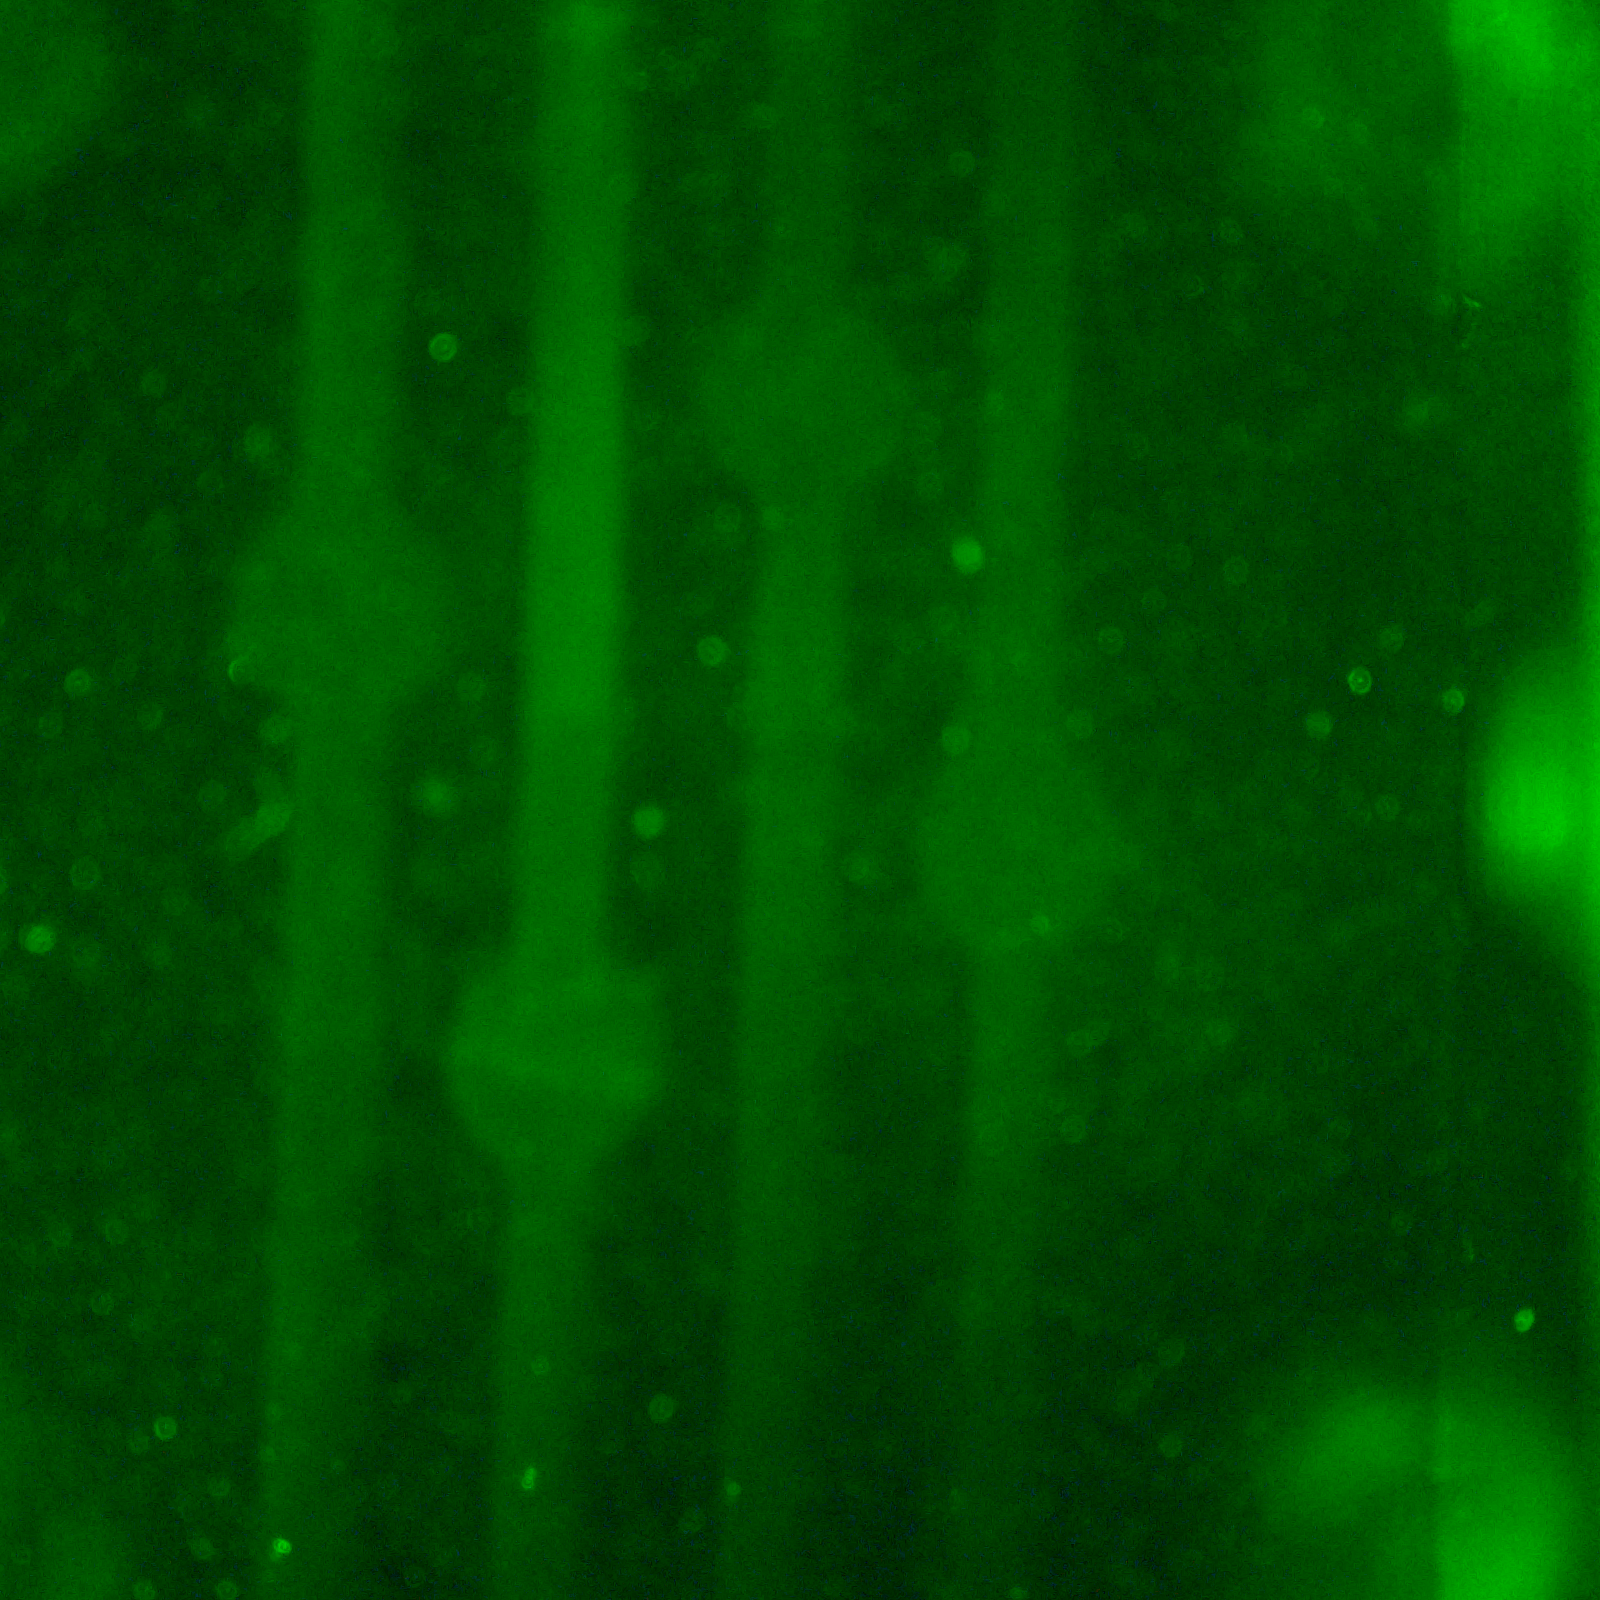

In [15]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

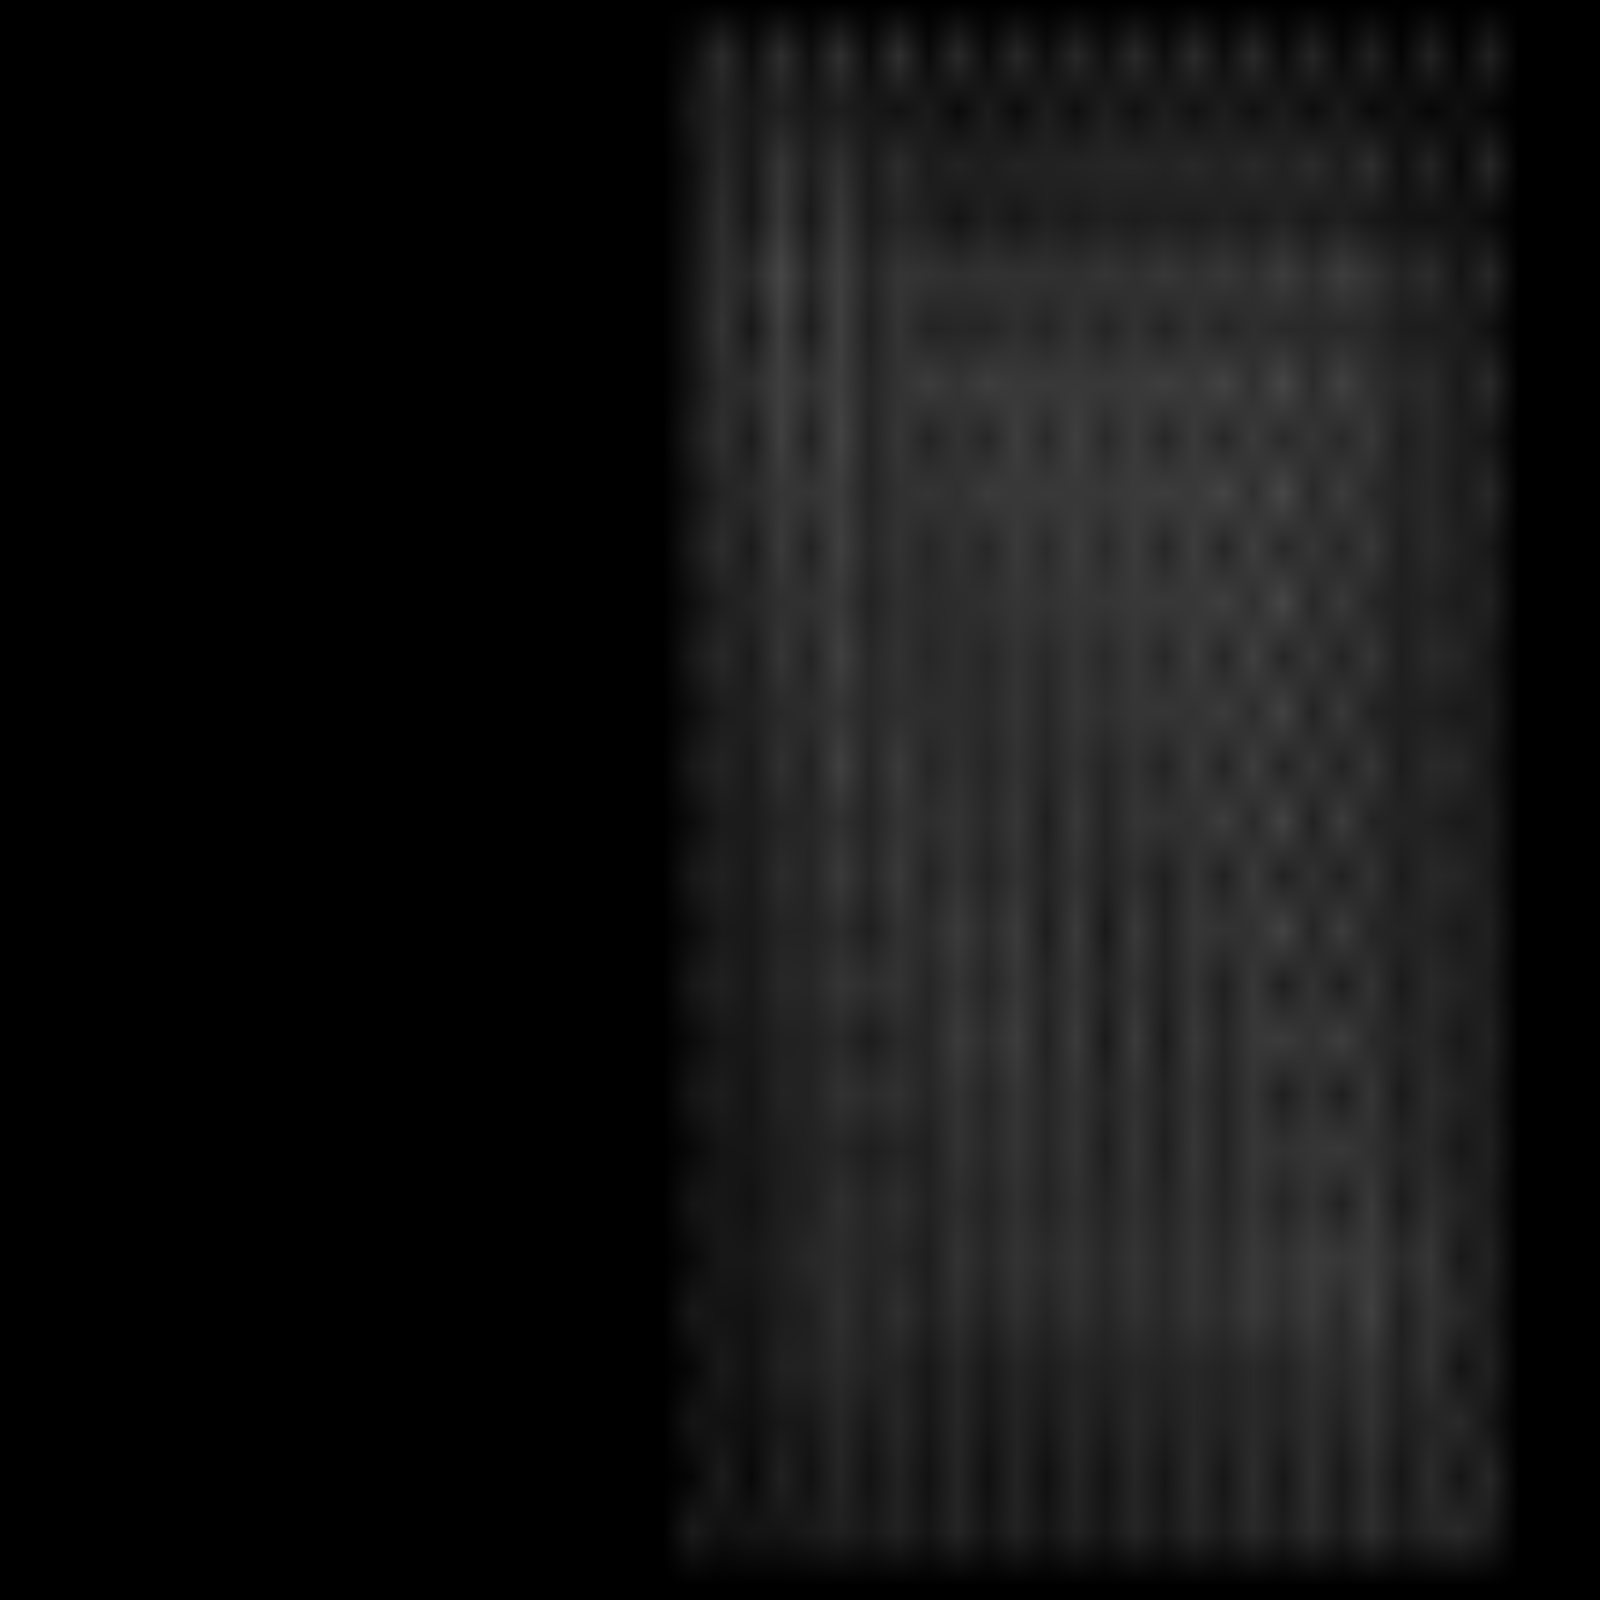

In [16]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())